In [1]:
import numpy as np
from PIL import Image
from skimage import color
import binascii
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random
import math

# Tyler Kann
## CSE 490  - Wireless Communications 
#### Python notebook with functions to do some image manipulation, but primarily with Hamming and LDPC decoding

In [2]:
def modReduce(matrix): 
    ''' does mod2 gaussian reduction to get a matrix in the form [Pt I] 
    inputs and outputs are in the form of a matrix
    
    '''
    matrix = matrix.astype(int)
    h = np.shape(matrix)[1] - len(matrix)  # halfway 
    for i in range(len(matrix)):
        tempRow = matrix[i].astype(int)

        if(matrix[i][h+i] == 1):
            ones = (np.where(matrix[:,h+i] == 1)[0])
            matrix[ones] = (matrix[i] != matrix[ones]).astype(int)
            matrix[i] = tempRow
        else:
            if(np.sum(matrix[h:,h+i]) == 0):
                return "break"
            swap = (np.where(matrix[h:,h+i] == 1)[0][0])
            tempNewRow = matrix[swap].astype(int)
            matrix[i] = tempNewRow
            matrix[swap] = tempRow
            onesNew = (np.where(matrix[:,h+i] == 1)[0])
            tempRow = matrix[i].astype(int)
            matrix[onesNew] = (matrix[i] != matrix[onesNew]).astype(int)
            matrix[i] = tempRow

    return matrix
            


def makeG(H): 
    '''Given a matrix H_reduced in the form [Pt I], will output a generator patrix in the form [I P]'''
    k = len(H)
    n = np.shape(H)[1]
    Pt_l = n-k
    Pt = H[:,0:Pt_l]
    I = np.identity(k)
    Pt = Pt.T
    G = np.hstack((I,Pt))
    return G



In [3]:
def makeHandG(n,k, ones):
    ''' Inputs : n , k (both matrix dimensions), and the percent of ones to be contained in the sparse matrix 
    ones must be between (0,1) - but will probably break if it is too low or too high; probably best around ~.4-.5
    outputs H, G
    i believe n,k cannot be coprime
    if you get a recursion error just run again - it just meant you happened to get unlucky and generate unsolveable matrices
    '''
    
    total = n*k
    percent = int(ones*total)
    rest = total - percent
    oneList = np.ones(percent)
    zeros = np.zeros(rest)

    
    cm = np.concatenate([oneList,zeros])
    np.random.shuffle(cm)
    np.random.shuffle(cm)
    H = cm.reshape((k,n))
    
    regular = int(n*k*ones//n)
    while((np.min(np.sum(H,0)) <= 2) or ((np.min(np.sum(H,1)) <= 1))): 
        np.random.shuffle(cm)
        H = cm.reshape((k,n))
    H_red = modReduce(H)
    if(isinstance((H_red), str)): 
        return makeHandG(n,k,ones)
    if(np.min(sum(H_red[:,n-k:])) == 0):
        return makeHandG(n,k,ones)     
    return H.astype(int), makeG(H_red).astype(int)

Hham, Gham = (makeHandG(14,7,.5))
H, G = makeHandG(16,8,.5)




In [4]:
# NOTE if you ever get any errors with it saying not able to conver size [x] into size [y] it most likely has something to do 
# with the np.empty type as <U12 , <U16, etc. you can just increase that number to the right size. 

def rgb2gray(rgb):
    '''Given an image with rgb, will output the grayscale equivalent'''
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def grayToBin(img): 
    '''given an image that is all gray, will output the numbers (0-255) in bytes (string)'''
    y_col = np.shape(img)[0]
    x_col = np.shape(img)[1]
    temp = np.empty((y_col, x_col), dtype ="<U12")
    for i in range(y_col):
        for j in range(x_col): 
            holder = str((bin(img[i][j])[2:]))
            while(len(holder) != 8): 
                holder = "0" + holder
            temp[i][j] = holder
    return temp

def binToGray(img): 
    '''given an array of strings of binary bytes, will give you grayscale (0-255)'''
    y_col = np.shape(img)[0]
    x_col = np.shape(img)[1]
    temp = np.zeros((y_col, x_col))
    for i in range(y_col):
        for j in range(x_col): 
            temp[i][j] = int(str(int(img[i][j])),2)
    return temp.astype(int)

def numberToArray(lst): 
    '''Converts a number (e.g. '1001') to an array ([1,0,0,1])'''
    temp = []
    lst = str(lst)
    for i in range(len(lst)):
        temp.append(int(lst[i]))
    return temp

def arrayToNumber(arr): 
    '''Converts an array (e.g [1,0,0,1] to a number (1001))'''
    arr = np.flip(arr)
    temp = 0
    a = 0
    for i in arr:
        temp = temp + i*10**(a)
        a += 1
    return int(temp)

def arrayToStr(arr, stop = 8): 
    '''Converts an array to a string 
        inputs stop as well to set the length (default one byte)
        e.g (stop = 8, [0,0,0,0,1,1,1,1] -> "00001111") 
        '''
    arr = np.flip(arr)
    temp = 0
    a = 0
    for i in arr:
        temp = temp + i*10**(a)
        a += 1
    holder = str(int(temp))
    while(len(holder) < stop): 
        holder = "0" + holder
    return holder

def add_noise(msg, prob, seed = 0):
    '''
    takes a binary array (msg), as well as the error rate (e.g .05) 
    optional seed
    outputs a new message with uniform bit flips proporitional to prob
    e.g 1001, .5 -> 0101 
    '''
    if (seed != 0): 
        np.random.seed(seed)
    else: 
        np.random.seed()
    rate = 1 - prob;
    errors = ((np.random.random(len(msg))>rate)).astype(int)
    return abs(msg-errors)

def add_noise_img(img, prob, seed = 0, binary = 0):
    '''Given a image (grayscale or binary; binary = 0|1 respectively), prob for error rate and optional seed 
    returns binary image with noise using the add_noise feature
    '''
    # binary is if the image is converted to binary, else assuming its a grayscale jpg
    y_col = np.shape(img)[0]
    x_col = np.shape(img)[1]
    temp = np.zeros((y_col, x_col)).astype(int)
    if (binary == 0):
        img = grayToBin(img)
    for i in range(y_col):
        for j in range(x_col): 
            tempArray = numberToArray(img[i][j])
            temp[i][j] = arrayToNumber(add_noise(tempArray, prob, seed))
    return binToGray(temp)

def add_noise_bnimg(img, prob, seed = 0, binary = 0):
    ''' adds noise to a binary image with uniform distribution from probability prob
    option seed 
    '''
    result = len(img[0][0])
    y_col = np.shape(img)[0]
    x_col = np.shape(img)[1]
    temp = np.empty((y_col, x_col), dtype ="<U24")
    for i in range(y_col):
        for j in range(x_col): 
            tempArray = numberToArray(img[i][j])
            temp[i][j] = arrayToStr(add_noise(tempArray, prob, seed), result)
    return temp


def split_bit(bimg, n=4, text = 0):
    '''
    Takes an image, as well as how often it needs to split the bytes and outputs a larger matrix
    if it is just a single message (not an image) use text = 1
    
    e.g. a binary matrix will all values equal to "10010101" of size 255x255 with n = 4 would output 
        a binary matrix of size 255x(255*2) with values alternating between "1001" and "0101"
        
    Mainly just used to set up a byte for hamming code
    
    '''
    if(text ==1):
        bimg = ((np.asarray(bimg).reshape(1,len(bimg))))
    ln = int(len(str(bimg[0][0]))//n)
    y_col = np.shape(bimg)[0]
    x_col = np.shape(bimg)[1]
    temp = np.empty((y_col, x_col*ln), dtype ="<U10")
    for i in range(y_col):
        c = 0
        for j in range(0,x_col*ln, ln):
            tempArray = str(bimg[i][c])
            if(len(tempArray) != 8):
                print("error")
            a = 0
            b = 0
            for k in range(ln):
                temp[i][j+k] = ((tempArray[(k)*n:(k+1)*n]))
                a += 1
                b += 1
            c+= 1
    return temp

def syndrome(encoded, pc):
    '''
    Used to decode messages w/ hamming
    inputs are the encoded matrix (with noise) and the hamming matrix itself
    the length should be 7  - 4 message bytes 3 parity bytes
    output is the decoded (error corrected) message
    '''
    y_col = np.shape(encoded)[0]
    x_col = np.shape(encoded)[1]
    temp = np.empty((y_col, x_col), dtype ="<U10")
    for i in range(y_col): 
        for j in range(x_col):
            x = numberToArray(encoded[i][j])
            x = np.reshape(x, (-1,1))
            holder = np.mod(pc.dot(x).T,2)
            T = holder
            x = x.T
            if (np.sum(T) == 0): ## LUT
                a = 0# do nothing
            elif (np.min(np.equal(T, np.array([0,0,1])).astype(int)) == 1):
                x[0][6] = np.abs(x[0][6]-1)
            elif (np.min(np.equal(T, np.array([0,1,0])).astype(int)) == 1):
                x[0][5] = np.abs(x[0][5]-1)
            elif (np.min(np.equal(T, np.array([0,1,1])).astype(int)) == 1):
                x[0][3] = np.abs(x[0][3]-1)
            elif (np.min(np.equal(T, np.array([1,0,0])).astype(int)) == 1):
                x[0][4] = np.abs(x[0][4]-1)
            elif (np.min(np.equal(T, np.array([1,0,1])).astype(int)) == 1):
                x[0][0] = np.abs(x[0][0]-1)
            elif (np.min(np.equal(T, np.array([1,1,0])).astype(int)) == 1):
                x[0][1] = np.abs(x[0][1]-1)
            else:
                x[0][2] = np.abs(x[0][1]-1)
            temp[i][j] = arrayToStr(x[0], 7)    
    return temp
        
def ham_revert(decode, n = 2):
    '''takes in a decoded binary msg (decode comes from syndrome()), with a second parameter of original image size/4 
       e.g a byte would have n = 2 because 8/4 = 2
       outputs a binary, error corrected message, with each index being len(decode) * n 
    '''
    y_col = np.shape(decode)[0]
    x_col = np.shape(decode)[1]
    temp = np.empty((y_col, x_col//n), dtype ="<U10")
    for i in range(y_col):
        a = 0
        for j in range(0,x_col//n):
            string = ""
            for k in range(n): 
                string = string + (decode[i][a+k][0:4])
            temp[i][j] = string
            a += n
    return temp

def singlebf(noise, real): 
    ''' compares two images, outputs total 1 bit errors, the total errors, and all errors w/ more than two bit flips per byte '''
    y_col = np.shape(noise)[0]
    x_col = np.shape(noise)[1]

    temp = 0
    temp1 = 0
    temp2 = 0
    for i in range(y_col): 
        for j in range(x_col):
            comp1 = numberToArray(noise[i][j])
            comp2 = numberToArray(real[i][j])
            SUM = np.sum(np.not_equal(comp1, comp2).astype(int))
            if(SUM == 1):
                temp += (1)
            if(SUM > 0):
                temp1 += 1
            if(SUM >2):
                temp2 += 1
    return temp, temp1, temp2

In [5]:
def encode(bn, cm): 
    '''encodes a binary string matrix with a checkmat (usually hamming)'''
    y_col = np.shape(bn)[0]
    x_col = np.shape(bn)[1]
    temp = np.empty((y_col, x_col), dtype ="<U10")
    for i in range(y_col): 
        for j in range(x_col): 
            x = numberToArray(bn[i,j])
            x = ((np.asarray(x).reshape(-1,1)))
            tempStr = arrayToStr(np.mod(cm.dot(x).T,2)[0],  np.shape(cm)[0])
            temp[i][j] = tempStr
    return temp

In [6]:
def hardDecide(msg, cp, maxtry = 200, trialNum = 0): 
    msg = np.asarray(msg)
    voteHold = np.zeros(np.shape(cp)[1]) 
    voteHoldHolder = np.zeros(np.shape(cp)[1])
    breaker = 0
    """Basically, you are going to have
    a sparse graph (cp), and your error containing message (msg) (typically 1 byte long). It will look at each check node, 
    and look at the other n v-nodes attached to it. It will then predict based on the n v nodes, if this specific node should 
    be 1 or 0 to make it even. It will loop through all check nodes. Once it is done, based on how many votes there were, 
    It will decide by majority vote whether to make it a 1 or 0. If its tied, its remains unchanged. 
    
    inputs a 1 dimensional message array encoded by G, along with H. The maxtry is when to break the iteration... 
    
    trialNum is only here because it's recursive (break when trialNum == maxtry)
    """
    if(sum(np.mod(cp.dot(msg.T),2)) == 0):
        return msg
    
    if (trialNum >= maxtry):
        return msg
    for j in range(len(cp)):
        checks = np.where(cp[j] == 1)[0]
        temp = msg[[checks]]
        for i in checks:
            fourthbit = msg[i]
            tester = np.mod(sum(temp) - fourthbit,2)
            voteHold[i] = (voteHold[i] + tester) 
            voteHoldHolder[i] += 1
    for i in range(np.shape(cp)[1]):
        voteHold[i] = voteHold[i]/voteHoldHolder[i]

        if(voteHold[i] > .5):
            breaker += int(msg[i] != 1)
            msg[i] = 1

        elif(voteHold[i] < .5):
            breaker += int(msg[i] != 0)
            msg[i] = 0
        
    if (breaker == 0):
        return msg
    newMsg = msg
    return (hardDecide(newMsg, cp, trialNum = trialNum + 1))
    
        # dont alter if tied.
    # rerun with new message, for further changes (if necessisary) 
        
    
    

In [7]:
def softDecide(msg, pc, e, maxtry = 150):
    
    ''' Soft decide is going to take in a 1 dimensional message, along with the parity check matrix H, the error rate you are using
        (in real situations you can predict the error rate) and when you want it to break (maxtry)
    ''' 
    pis = np.zeros(len(msg))
    for i in range(len(pis)): 
        if (msg[i] == 1):
            pis[i] = 1-e
        else:
            pis[i] = e
    # This is basically finding Pi which is P(1|y) i.e. if it is seen as a 1, what is it (error rate)
    qji = np.zeros((np.shape(pc)[0], np.shape(pc)[1]))
    # initializing qjis (since we dont know any better, qji can just be pi for now )
    for j in range(np.shape(pc)[0]):
        qji[j] = pis
    r1ji = np.zeros((np.shape(pc)[0], np.shape(pc)[1]))
    r0ji = np.zeros((np.shape(pc)[0], np.shape(pc)[1]))
    Qi1 = np.zeros(np.shape(pc)[1])
    Qi0 = np.zeros(np.shape(pc)[1])
    pct = pc.T
    vote = np.zeros(len(msg))
    for j in range(np.shape(pc)[0]):
        checks = np.where(pc[j] == 1)[0] #finding all the v nodes within each check node 
        for i in checks:
            r0ji[j][i] = softDecideMath1(qji[j], checks, i) #using a helper function
            r1ji[j][i] = 1 - r0ji[j][i] # this is just 1 - p(0) given the complete set is always 1 
            # now we have found rji(0) and rji(1)
    for i in range(np.shape(pc)[1]): # for this we want to use other check nodes for each given v node
        checks = np.where(pc[:,i] == 1)[0]
        for j in checks:
            r0 = np.prod(r0ji[:,i][checks])/r0ji[:,i][j] #We are going to update qji, using r(0) and r(1). We  
            r1 = np.prod(r1ji[:,i][checks])/r1ji[:,i][j] # want to use all the check node bits in H except the one we are 
            r1 = pis[i]*r1                               # currently on. The easiest way in python is just np.prod()/(element)
            r0 = (1-pis[i])*r0                         # these specific equations can be found in Bernhard M.J. Leiner 2005 tutorial
            norm = (r1 + r0)                           # we are finding a constant K such that these temp vars r0 and r1 = 1
            Kij = 1/norm
            r0 = Kij*r0
            r1 = Kij*r1
            qji[j][i] = r1                               # we update qji for that specific spot in the H matrix
            
        r0 = np.prod(r0ji[:,i][checks])               # To find capital Q (which we use for our decision making)
        r1 = np.prod(r1ji[:,i][checks])               # its nearly the same process except we do include the node we are currently on aka just np.prod
        r1 = pis[i]*r1
        r0 = (1-pis[i])*r0
        norm = (r1 + r0)
        Kij = 1/norm
        r0 = Kij*r0
        r1 = Kij*r1
        vote[i] = int(r1>r0)                            # if Q(1) > Q(0), we predict it to be 1. else its 0. 
        
    if(sum(np.mod(pc.dot(vote.T),2)) == 0):             # a working message (i.e. a corrected one) will have the property Hx = 0
        return vote
    else:
        return LDPCHelper(vote, pc, e, qji, pis, maxtry = 150, no = 1) # recursive process using the LDPC helper function (exact same logic)
                                                                       # the only difference is we use the qji we found instead of assuming they are Pi
        
        
            
    

In [8]:
def LDPCHelper(msg, pc, e, qji, pis, maxtry = 150, no = 1):
    if(no >= maxtry): #prevent infinite loop
        return msg
        
    r1ji = np.zeros((np.shape(pc)[0], np.shape(pc)[1]))
    r0ji = np.zeros((np.shape(pc)[0], np.shape(pc)[1]))
    Qi1 = np.zeros(np.shape(pc)[1])
    Qi0 = np.zeros(np.shape(pc)[1])
    pct = pc.T
    vote = np.zeros(len(msg))
    for j in range(np.shape(pc)[0]):
        checks = np.where(pc[j] == 1)[0]
        for i in checks:
            r0ji[j][i] = softDecideMath1(qji[j], checks, i)
            r1ji[j][i] = 1 - r0ji[j][i]
    for i in range(np.shape(pc)[1]): 
        checks = np.where(pc[:,i] == 1)[0]
        for j in checks:

            r0 = np.prod(r0ji[:,i][checks])/r0ji[:,i][j]
            r1 = np.prod(r1ji[:,i][checks])/r1ji[:,i][j]
            r1 = pis[i]*r1
            r0 = (1-pis[i])*r0
            norm = (r1 + r0)
            Kij = 1/norm
            r0 = Kij*r0
            r1 = Kij*r1
            qji[j][i] = r1 
            
        r0 = np.prod(r0ji[:,i][checks])
        r1 = np.prod(r1ji[:,i][checks])
        r1 = pis[i]*r1
        r0 = (1-pis[i])*r0
        norm = (r1 + r0)
        Kij = 1/norm
        r0 = Kij*r0
        r1 = Kij*r1
        vote[i] = int(r1>r0)
        
    if(sum(np.mod(pc.dot(vote.T),2)) == 0):
        return vote
    else:
        return LDPCHelper(vote, pc, e, qji, pis, maxtry = 150, no = no + 1)
        

In [9]:
def softDecideMath1(ps, checks, i):
    a = (1 - 2*ps[[checks]])
    remove = (1-2*ps[i])
    b = np.prod(a)/remove
    return (b + 1)/2

In [10]:
def ldpcEncode(bn, Gin):
    '''encodes a binary string matrix with a checkmat (usually LDPC)  codeword = xG'''
    y_col = np.shape(bn)[0]
    x_col = np.shape(bn)[1]
    temp = np.empty((y_col, x_col), dtype ="<U24")
    for i in range(y_col): 
        for j in range(x_col): 
            x = np.asarray(numberToArray(bn[i,j]))
            x = np.asarray(x)
            x = np.array(x, dtype=np.int32)
            a = x.dot(Gin)
            tempStr = arrayToStr(np.mod(a,2),  stop = np.shape(Gin)[1])
            temp[i][j] = tempStr
    return temp

In [13]:
def ldpcDecode(bn, Hin, e, soft = 1): 
    
    """ takes a binary image bn, a check matrix Hin, an error rate e, and soft = 1/0 soft decide/ hard decide
        does ldpc decoding on an entire image (very slow)
    """
    y_col = np.shape(bn)[0]
    x_col = np.shape(bn)[1]
    temp = np.empty((y_col, x_col), dtype ="<U24")
    for i in range(y_col):
        for j in range(x_col):
            y = np.asarray(numberToArray(bn[i,j]))
            if(soft): 
                decode = softDecide(y, Hin, e)
            else:
                decode = hardDecide(y, Hin) 
            temp[i][j] = arrayToStr(decode, len(decode))    
    return temp

In [15]:
def ldpc_revert(bn, Hin):
    "given it went through the ldpc process w/ Hin, it will reconvert from a codeword to just information bits"
    
    y_col = np.shape(bn)[0]
    x_col = np.shape(bn)[1]
    temp = np.empty((y_col, x_col), dtype ="<U24")
    if(len(bn) == len(Hin)):
        size = len(Hin.T)
    else: 
        size = len(Hin)
    for i in range(y_col):
        for j in range(x_col):
            x = bn[i,j][0:size]
            temp[i,j] = x
    return temp


In [16]:
def totalError(gray, noisy_img):
    '''compares two images and sees how many pixels (percentage) have errors'''
    return np.sum(((gray != noisy_img)).astype(int))/(np.shape(gray)[0]*np.shape(gray)[1])

In [17]:
def msg_converter(msg):
    a = 0
    b = 8
    for i in range(len(msg)//8):
        for j in range(a,b):
            print(msg[j], end = '')
        print(" ", end = '')
        a += 8
        b += 8
    print()

In [18]:
CheckMat = np.array([[0, 1, 0, 1, 1, 0, 0, 1],
[1, 1, 1, 0, 0, 1, 0, 0],
[0, 0, 1, 0, 0, 1, 1, 1],
[1, 0, 0, 1, 1, 0, 1, 0]])


HammingG = np.array([[1, 0, 0, 0],
                       [0, 1, 0, 0],
                       [0, 0, 1, 0],
                       [0, 0, 0, 1],
                       [1, 1, 1, 0],
                       [0, 1, 1, 1],
                       [1, 0, 1, 1]])


G_ = np.array([[1,    1,    0,    1,],
              [1,    0,    1,    1,],
              [1,    0,    0,    0,],
              [0,    1,    1,    1,],
              [0,    1,    0,    0,],
              [0,    0,    1,    0,],
              [0,    0,    0,    1]])


HammingH = np.array([[1,1,1,0,1,0,0],
               [0,1,1,1,0,1,0],
               [1,0,1,1,0,0,1]])

LDG = np.array([[1, 0, 0, 1, 0, 1, 0, 1],
                [0, 1, 0, 0, 1, 1, 0, 0],
                [0, 1, 1, 1, 0, 1, 1, 0],
                [1, 0, 1, 0, 1, 0, 0, 1]])

# useful matrices



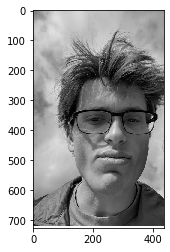

Default Image


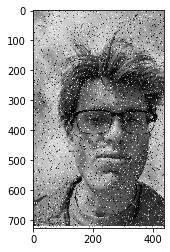

Noisy Image
Error rate is  0.3361042999820585
0.30175889757285984


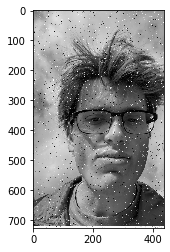

Image after noise, corrected using hamming method
Error rate is  0.11646243771620307


C:\Users\tyste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


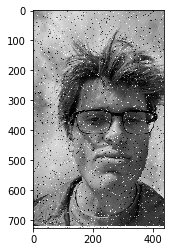

Image after noise, corrected using ldpc method w/ soft decision
Error rate is  0.17847081671645174


C:\Users\tyste\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


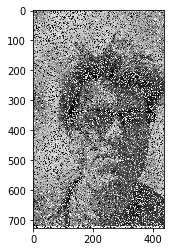

Image after noise, corrected using ldpc method w/ hard decision
Error rate is  0.5300488827475063


In [ ]:
# Main

img = mpimg.imread('Picture1.jpg')      # <- Use any jpg here 
gray = np.round(rgb2gray(img)).astype(int)    
plt.imshow((gray), cmap=plt.get_cmap('gray'))
plt.show()


print("Default Image")

binImg = grayToBin(gray) 
binImg4x2 = split_bit(binImg) # converts 225x225 to 450x225 making all bytes usable for hamming



testEncode = encode(binImg4x2, HammingG) # hamming encode
testEncodeLDPC = ldpcEncode(binImg, G) # ldpc encode 
testEncodeLDPCHam = ldpcEncode(testEncode, Gham) # ldpc and hamming 
 
testNoise = add_noise_bnimg(testEncode, .05) # add noise to all the encoded 
testNoiseLDPC = add_noise_bnimg(testEncodeLDPC, .05)
testNoiseLDPCHam = add_noise_bnimg(testEncodeLDPCHam, .05)


plt.imshow((binToGray(ham_revert(testNoise))), cmap=plt.get_cmap('gray'))
plt.show()
print("Noisy Image")

print("Error rate is ", totalError(binImg,ham_revert(testNoise))) #Even though a bitflip is only a small probability e, each pixel is a byte, 
# so the actual rate of error is 1-(1-e)^8.
print(totalError(testEncode,testNoise))

### going to correct all the error rates, and print what method it used, and what the error rate it got was 

correctedErrorHamming = ham_revert(syndrome(testNoise, HammingH))


plt.imshow((binToGray(correctedErrorHamming)), cmap=plt.get_cmap('gray'))
plt.show()
print("Image after noise, corrected using hamming method")


print("Error rate is ", totalError(binImg,correctedErrorHamming)) #Even though a bitflip is only a small probability e, each pixel is a byte, 
# so the actual rate of error is 1-(1-e)^8.


correctedErrorLDPC = ldpc_revert(ldpcDecode(testNoiseLDPC, H, .05), H)

plt.imshow((binToGray(correctedErrorLDPC)), cmap=plt.get_cmap('gray'))
plt.show()
print("Image after noise, corrected using ldpc method w/ soft decision")


print("Error rate is ", totalError(binImg,correctedErrorLDPC)) 



correctedErrorLDPCHard = ldpc_revert(ldpcDecode(testNoiseLDPC, H, .05, soft = 0), H)

plt.imshow((binToGray(correctedErrorLDPCHard)), cmap=plt.get_cmap('gray'))
plt.show()
print("Image after noise, corrected using ldpc method w/ hard decision") #not sure why this GENERATEs errors


print("Error rate is ", totalError(binImg,correctedErrorLDPCHard)) 


correctedErrorLDPCHam = ldpc_revert(ldpcDecode(testNoiseLDPCHam, Hham, .05), Hham)
correctedErrorLDPCHam1 = ldpc_revert(correctedErrorLDPCHam, Hham)
correctedErrorLDPCHam2 = ham_revert(syndrome(correctedErrorLDPCHam1, HammingH))

plt.imshow((binToGray(correctedErrorLDPCHam2)), cmap=plt.get_cmap('gray'))
plt.show()
print("Image after noise, corrected using ldpc method w/ soft decision followed by hamming")


print("Error rate is ", totalError(binImg,correctedErrorLDPCHam2)) 



In [437]:
test

trials = 20
noise =[]
hamNoise = []
pred = []
act = []
newtest = []
for i in range(trials):
    testNoise = add_noise_bnimg(testEncode, .05*i)
    single = singlebf(ham_revert(testNoise), binImg)
    newtest.append(totalError(ham_revert(syndrome(testNoise, HammingH)), binImg)/totalError(testEncode, testNoise))
    pred1 = 1-(1-.05*i)**8
    act.append(testNoise)
    noise.append(single)
    pred.append(pred1)

    noise1 = []
noise1 = [i[1]/(225*225) for i in noise]



C:\Users\tyste\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [447]:
noise2 = [i[0]/(225*225) for i in noise]
newtest2 = [1 - i for i in newtest]
onebit = [8*(1-.05*i)**7*(.05*i) for i in range(20)]

Text(0.5, 0, 'Bit Error Rate')

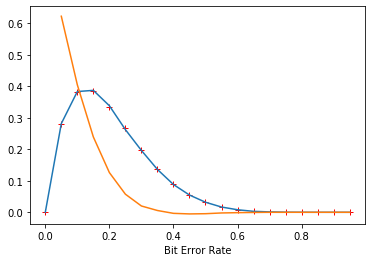

In [448]:
n = np.arange(0,20)*.05
plt.plot(n, onebit, 'r+')
plt.plot(n, noise2)
plt.plot(n, newtest2)
plt.xlabel("Bit Error Rate")

# hamming in theory corrects every one bit error 
# here i am plotting the one bit errors versus the percent of errors hamming corrects 
# maybe someone can interpret this graph for me : ) 
# i am very acurrately predicting one bit errors, which is nice (its a binomial)